<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# Ejercicio de clasificación con Random Forest

Ejemplo de clasificación utilizando random forest para la clasificación de drogadas que debería tomar un pasiente según su historial clínico<br>

v1.1

In [ ]:
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.utils import to_categorical

# Recolectar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline1.png" width="1000" align="middle">

In [ ]:
if os.access('drug200.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv > drug200.csv
    else:
        !wget drug200.csv https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv

--2020-11-15 14:02:10--  http://drug200.csv/
Resolving drug200.csv (drug200.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘drug200.csv’
--2020-11-15 14:02:10--  https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6027 (5.9K) [text/plain]
Saving to: ‘drug200.csv’

drug200.csv         100%[===================>]   5.89K  --.-KB/s    in 0s      

2020-11-15 14:02:11 (71.8 MB/s) - ‘drug200.csv’ saved [6027/6027]

FINISHED --2020-11-15 14:02:11--
Total wall clock time: 0.2s
Downloaded: 1 files, 5.9K in 0s (71.8 MB/s)


### `drug200.csv`:
El dataset **`drug200.csv`** contiene diferentes tipos de drogas que se le dan a pacientes relativo a su historial clínico. El objetivo es dado un nuevo paciente clasificarlo y determinar que droga es la más apropiada para el.<br> [Dataset source](https://www.kaggle.com/jeevanrh/drug200csv)

- **Age** --> edad, ejemplo 25
- **Sex** --> género, ejemplo F(femenino), M(masculino)
- **BP (Blood Pressure)** --> presión arterial, ejemplo HIGH(alta)
- **Cholesterol** --> colesterol, ejemplo normal (NORMAL)
- **Na / k** --> concentración de sodio/potasio en sangre, ejemplo 7.8
- **Drug** --> droga suministrada, ejemplo drugC

# Procesar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline2.png" width="1000" align="middle">

In [ ]:
df = pd.read_csv("drug200.csv")
des = df.describe()
des.loc['Nan'] = df.isna().sum()
des.loc['%Nan'] = (df.isna().mean())*100
des

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000
Nan,0.000000,0.000000
%Nan,0.000000,0.000000


In [ ]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [ ]:
print('Cantidad de datos en observacion:', df.shape[0])

Cantidad de datos en observacion: 200


# Explorar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline3.png" width="1000" align="middle">

In [ ]:
# Exploramos que tan balanceado está el dataset,
# en cuantos casos se suministró cada droga
df['Drug'].value_counts()

drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

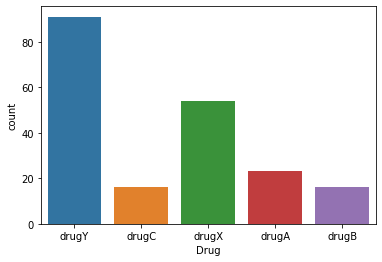

In [ ]:
ax = sns.countplot(data=df, x="Drug")

Se puede observar que en la mayoría de los casos se suministra la drogaY oa la drogaX, es muy probable que el modelo siga esta tendencia

#### Transformar variables categóricas texto a clases numeradas

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

df_cod = df.copy()
df_cod['DrugY'] = df_cod['Drug'].apply(lambda x: 1 if x == 'drugY' else 0)
df_cod = df_cod.drop('Drug', axis=1)

In [ ]:
df_cod.head()

,Age,Sex,BP,Cholesterol,Na_to_K,DrugY
0,23,F,HIGH,HIGH,25.355,1
1,47,M,LOW,HIGH,13.093,0
2,47,M,LOW,HIGH,10.114,0
3,28,F,NORMAL,HIGH,7.798,0
4,61,F,LOW,HIGH,18.043,1


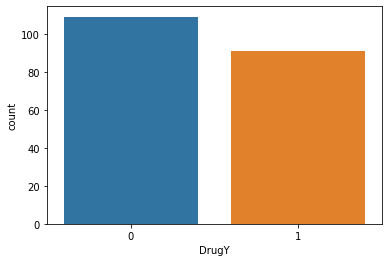

In [ ]:
ax = sns.countplot(data=df_cod, x="DrugY")

In [ ]:
def one_hot_encoding(df, column):
    df_copy = df.copy()
    # LabelEncoder
    le = LabelEncoder()
    label_encoding = le.fit_transform(df_copy[column])
    # OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoding = onehot_encoder.fit_transform(label_encoding.reshape(-1, 1))
    # Crear las columnas con el resultado del encoder
    one_hot_encoding_df = pd.DataFrame(one_hot_encoding, columns=le.classes_, dtype=int)
    # Agregar sufijo
    one_hot_encoding_df = one_hot_encoding_df.add_prefix(column+'_')
    # Unir nuevas columnas al dataset
    df_copy = df_copy.join(one_hot_encoding_df)
    # Eleminar vieja columna del dataset
    df_copy = df_copy.drop([column], axis=1)
    return df_copy


In [ ]:
df_cod = one_hot_encoding(df_cod, 'Sex')
df_cod = one_hot_encoding(df_cod, 'BP')
df_cod = one_hot_encoding(df_cod, 'Cholesterol')

In [ ]:
df_cod.head()

,Age,Na_to_K,DrugY,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,1,1,0,1,0,0,1,0
1,47,13.093,0,0,1,0,1,0,1,0
2,47,10.114,0,0,1,0,1,0,1,0
3,28,7.798,0,1,0,0,0,1,1,0
4,61,18.043,1,1,0,0,1,0,1,0


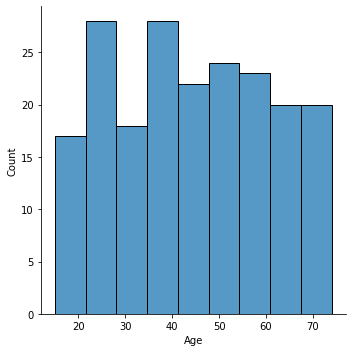

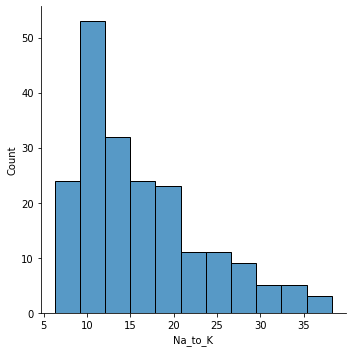

In [ ]:
sns.displot(data=df_cod, x='Age')
sns.displot(data=df_cod, x='Na_to_K')
plt.show()

In [ ]:
# Es importante normalizar los datos, ya que las redes funcionan con el proceso
# del gradiente descendente.
# Como "Age" no sigue una distribucion normal y "Na_to_K" no parece tener outliers
# utilizaremos el MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_norm = df_cod.copy()
df_norm.loc[:, 'Age'] = scaler.fit_transform(df_norm[['Age']])
df_norm.loc[:, 'Na_to_K'] = scaler.fit_transform(df_norm[['Na_to_K']])
df_norm.head()

,Age,Na_to_K,DrugY,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,0.135593,0.596848,1,1,0,1,0,0,1,0
1,0.542373,0.213397,0,0,1,0,1,0,1,0
2,0.542373,0.120239,0,0,1,0,1,0,1,0
3,0.220339,0.047814,0,1,0,0,0,1,1,0
4,0.779661,0.368191,1,1,0,0,1,0,1,0


# Entrenar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline4.png" width="1000" align="middle">

El primer paso es obtener los datos que serán la entrada del sistema (X) y los datos que serán la salida del modelo estimador (y)

In [ ]:
X = df_norm.drop('DrugY', axis=1).values
y = df_norm['DrugY'].values
in_shape = X.shape[1]
out_shape = 1

Siguiente paso es dividir el dataset en entrenamiento (train) y evaluación (test). Utilizaremos el criterio 80%20%

In [ ]:
from sklearn.model_selection import train_test_split
# Fijamos un "random_state" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from keras.layers import Dense

def create_model(input_size, hidden_neurons, output_size):
    # Crear un modelo secuencial
    model = Sequential()

    # Crear la capa de entrada y la capa oculta (hidden) de la red, que tendrá:
    # --> tantas entradas (input_shape) como columnas (input_size)
    # --> tantas neuronas como deseemos
    # --> utilizamos "sigmoid" como capa de activación
    model.add(Dense(units=hidden_neurons, activation='sigmoid', input_shape=(input_size,)))

    # Crear la capa de salida, que tendrá tantas neuronas como salidas posibles
    model.add(Dense(units=output_size, activation='sigmoid'))

    return model

In [ ]:
model = create_model(in_shape, 64, out_shape)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2 , epochs=50, batch_size=32)

Epoch 1/50
4/4 [==============================] - 0s 44ms/step - loss: 0.6948 - accuracy: 0.5357 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6809 - accuracy: 0.6250 - val_loss: 0.7015 - val_accuracy: 0.4643
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6716 - accuracy: 0.5536 - val_loss: 0.7147 - val_accuracy: 0.4643
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6647 - accuracy: 0.5536 - val_loss: 0.7085 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 0.6546 - accuracy: 0.6429 - val_loss: 0.7010 - val_accuracy: 0.4643
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6511 - accuracy: 0.6696 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 7/50
4/4 [==============================] - 0s 6ms/step - loss: 0.6416 - accuracy: 0.6696 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 8/50
4/4 [=================

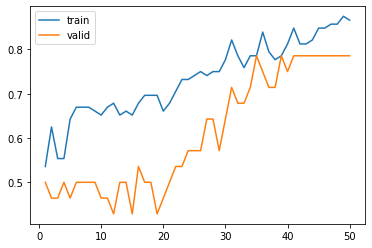

In [ ]:
epoch_count = range(1, len(history.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat = [1 if x >= 0.5 else 0 for x in y_hat_prob]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


# Validar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline5.png" width="1000" align="middle">

In [ ]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

2/2 [==============================] - 0s 2ms/step - loss: 0.4157 - accuracy: 0.8667


0.8666666746139526

In [ ]:
# Calcular la exactitud (accuracy)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat, normalize=True)


0.8666666666666667

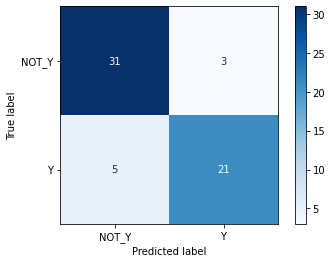

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=['NOT_Y', 'Y'])
cmd.plot(cmap=plt.cm.Blues)
plt.show()